# Gradcam图像分类(雾)

[Grad-CAM](https://zhuanlan.zhihu.com/p/617188022#:~:text=Grad-CAM%E6%98%AFGradient-weighted%20Class,Activation%20Mapping%E7%9A%84%E7%AE%80%E7%A7%B0%EF%BC%8C%E5%8D%B3%E6%A2%AF%E5%BA%A6%E5%8A%A0%E6%9D%83%E7%B1%BB%E6%BF%80%E6%B4%BB%E6%98%A0%E5%B0%84%E3%80%82)

[Grad-CAM的详细介绍Pytorch代码实现](https://zhuanlan.zhihu.com/p/623073818)


Grad-CAM（梯度加权类激活映射）是一种用于解释深度学习模型预测的方法。它通过分析神经网络中特定层的梯度信息，将模型的预测可视化为输入图像上的激活区域。这有助于理解模型在做出预测时关注的图像区域，提供了对深度学习模型决策的一定可解释性。Grad-CAM通常用于图像分类任务。

Grad-CAM 的基本思想是，在神经网络中，最后一个卷积层的输出特征图对于分类结果的影响最大，因此我们可以通过对最后一个卷积层的梯度进行全局平均池化来计算每个通道的权重。这些权重可以用来加权特征图，生成一个 Class Activation Map (CAM)，其中每个像素都代表了该像素区域对于分类结果的重要性。

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras.models import load_model
import cv2 as cv

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

2024-03-11 19:39:13.200030: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
os.getcwd()

'/home/jiajianhao/文档/cnn/Magnetic_methods-master/Gradcam'

In [3]:
## Useful functions
os.chdir('../')
from Utils.Utils_colab import *

## 训练集 验证集 测试集
以下皆为通用内容,详见[Densenet](../Densenet/Densenet121_par_SCRATCH_VO_withouttrain.ipynb)

In [4]:
def load_dataset_train_dev_test(dirname):


    X_train = np.load(dirname+"X_train.npy")  # your train set features
    X_dev = np.load(dirname+"X_dev.npy")  # your train set labels
    X_test = np.load(dirname+"X_test.npy")

    Y_train = np.load(dirname+"Y_train.npy")
    Y_dev = np.load(dirname+"Y_dev.npy")
    Y_test = np.load(dirname+"Y_test.npy")

    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

    # Path to the database

hdf5_path = './mydata/npy/'
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_dataset_train_dev_test(hdf5_path)

In [5]:
################ Confirming data retrieved shapes ###############

#Standardizing training data
#X_train_std = standardize_x_array(X_train)
#X_dev_std = standardize_x_array(X_dev)
#X_test_std = standardize_x_array(X_test)


print("X_train shape : " + str(X_train.shape), "X_dev shape : " + str(X_train.shape), "X_test shape : " + str(X_train.shape)) 
print("Y_train shape : " + str(Y_train.shape), "Y_dev par shape : " + str(Y_dev.shape), "Y_test par shape : " + str(Y_test.shape)) 

X_train shape : (816, 64, 64, 3) X_dev shape : (816, 64, 64, 3) X_test shape : (816, 64, 64, 3)
Y_train shape : (816, 5) Y_dev par shape : (256, 5) Y_test par shape : (52, 5)


In [6]:
from keras import backend as K

def r2(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()))


In [9]:
os.getcwd()

'/home/jiajianhao/文档/cnn/Magnetic_methods-master'

## 导入神经网络

In [11]:
load_path = "./content/my_Densenet_par_9_TL.hdf5"
best_model = load_model(load_path, custom_objects={'r2': r2})

best_model.summary()

2024-03-11 19:41:11.698043: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-11 19:41:11.699374: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-11 19:41:11.708940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-03-11 19:41:11.709189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-03-11 19:41:11.709219: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [12]:
i=0
for layer in best_model.layers:

    print(f"{i}: {layer.name}")
    i+=1

0: input_1
1: zero_padding2d
2: conv1/conv
3: conv1/bn
4: conv1/relu
5: zero_padding2d_1
6: pool1
7: conv2_block1_0_bn
8: conv2_block1_0_relu
9: conv2_block1_1_conv
10: conv2_block1_1_bn
11: conv2_block1_1_relu
12: conv2_block1_2_conv
13: conv2_block1_concat
14: conv2_block2_0_bn
15: conv2_block2_0_relu
16: conv2_block2_1_conv
17: conv2_block2_1_bn
18: conv2_block2_1_relu
19: conv2_block2_2_conv
20: conv2_block2_concat
21: conv2_block3_0_bn
22: conv2_block3_0_relu
23: conv2_block3_1_conv
24: conv2_block3_1_bn
25: conv2_block3_1_relu
26: conv2_block3_2_conv
27: conv2_block3_concat
28: conv2_block4_0_bn
29: conv2_block4_0_relu
30: conv2_block4_1_conv
31: conv2_block4_1_bn
32: conv2_block4_1_relu
33: conv2_block4_2_conv
34: conv2_block4_concat
35: conv2_block5_0_bn
36: conv2_block5_0_relu
37: conv2_block5_1_conv
38: conv2_block5_1_bn
39: conv2_block5_1_relu
40: conv2_block5_2_conv
41: conv2_block5_concat
42: conv2_block6_0_bn
43: conv2_block6_0_relu
44: conv2_block6_1_conv
45: conv2_block

### 生成Grad-CAM（梯度权重类激活映射）的热图
以下是代码的主要解释：

1. **选择卷积层和分类器层：**
   - `last_conv_layer_name` 表示用于生成Grad-CAM的最后一个卷积层的名称
   - `classifier_layer_names` 是一个包含分类器层名称的列表

2. **绘制设置：**
   - `height_2` 和 `width_2` 是图形的高度和宽度。
   - `Model_to_plot` 包含了要生成Grad-CAM的输入数据。


   - `zmax` 获取输入数据的深度。
   - `map_length` 定义了热图的范围。
   - `xmin`, `xmax`, `ymin`, `ymax` 定义了绘图区域的坐标范围。
   - `X` 和 `Y` 是用于绘制热图的坐标网格。

3. **绘制热图：**
   - 使用 `contourf` 函数绘制热图，采用了彩虹色调的颜色映射，表示磁感应强度。
   - x 和 y 轴的标签和刻度设置。



4. **保存图像：**
   - 使用 `savefig` 将生成的热图保存为 'gradcam_model.jpg' 文件，设置了dpi（每英寸点数）为100。

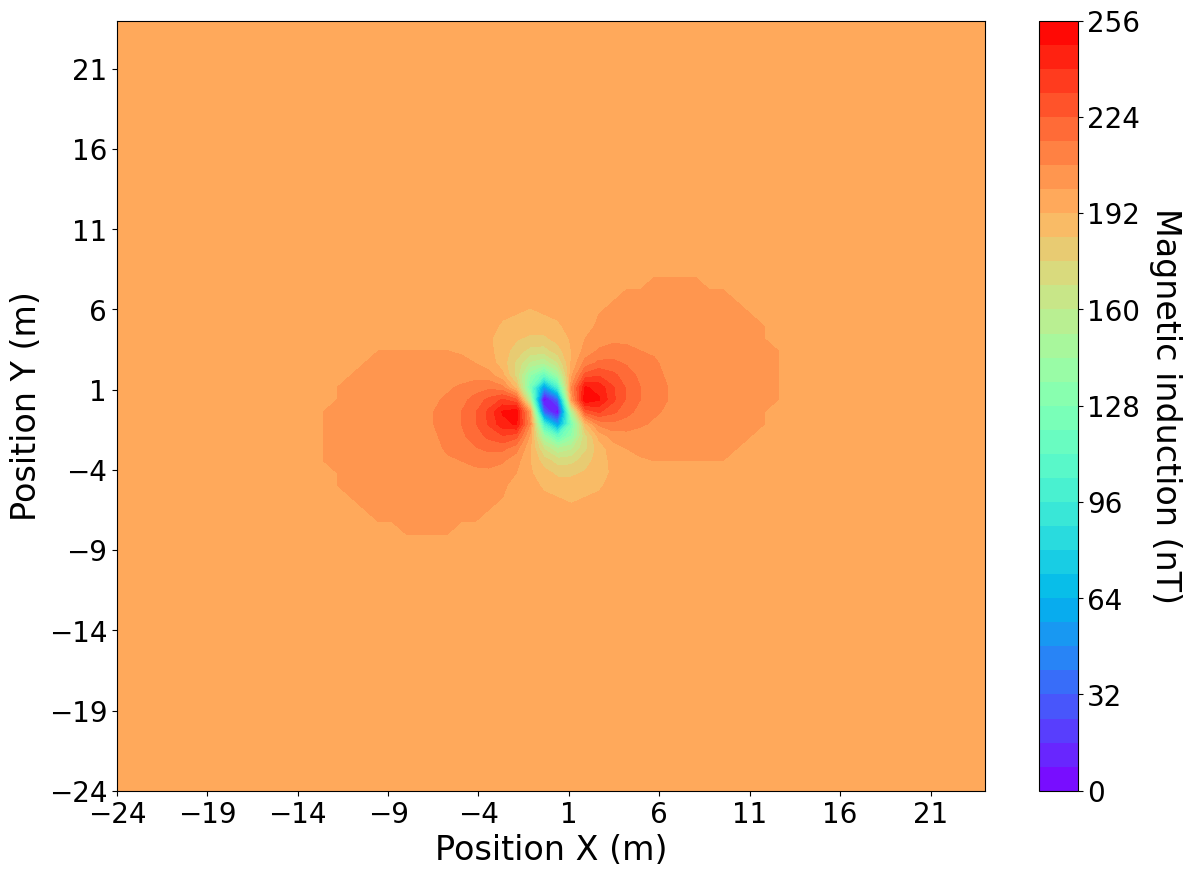

In [13]:
# 139: pool3_conv
# 141: Global_Average_Pooling_2D
last_conv_layer_name = "pool3_conv"
classifier_layer_names = ["Global_Average_Pooling_2D"]

height_2 = 10
width_2 = 14

plt.figure(figsize=(width_2, height_2))

model = 3
Model_to_plot = X_test[model:model+1]

zmax = X_train.shape[1]
map_length = 24

xmin = -map_length
xmax = map_length
ymin = -map_length
ymax = map_length

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)

# 绘制热图
plt.contourf(X, Y, Model_to_plot[0, :, :, 0], levels=40, cmap='rainbow')

plt.xlabel('Position X (m)', fontsize=24)
plt.xticks(np.arange(-24, 26, step=5), fontsize=20)
plt.ylabel('Position Y (m)', fontsize=24)
plt.yticks(np.arange(-24, 26, step=5), fontsize=20)

clb = plt.colorbar()
clb.ax.tick_params(labelsize=20)  # 调整颜色条标签的字体大小
clb.set_label('Magnetic induction (nT)', labelpad=30, y=0.5, rotation=270, fontsize=24)

plt.savefig('./Gradcam/gradcam_model.jpg', dpi=100)


### `make_gradcam_heatmap`的函数
这段代码定义了一个名为`make_gradcam_heatmap`的函数，用于生成使用Grad-CAM（梯度加权类激活映射）的热图。以下是代码的主要步骤：

1. **输入参数：**
   - `img_array`：输入图像，用于生成Grad-CAM热图。
   - `model`：神经网络模型。
   - `last_conv_layer_name`：模型中用于生成Grad-CAM的最后一个卷积层的名称。
   - `classifier_layer_names`：模型中用于分类的层的名称列表。

2. **创建卷积层模型：**
   - 通过提供输入图像，创建一个模型，该模型输出最后一个卷积层的激活值。这个模型被称为`last_conv_layer_model`。

3. **创建分类器模型：**
   - 创建一个模型，将最后一个卷积层的激活值映射到最终的类别预测。这个模型被称为`classifier_model`。

4. **计算梯度：**
   - 使用`tf.GradientTape`计算输入图像对于最后一个卷积层激活值的梯度。这个梯度用于确定对于最高预测类别而言，哪些部分对应于输入图像的重要部分。

5. **生成热图：**
   - 根据梯度和最后一个卷积层的激活值，生成Grad-CAM热图。通过加权每个通道，突显对最高预测类别贡献较大的部分。

6. **热图归一化：**
   - 将热图归一化到区间[0, 1]，以便可视化。

7. **返回结果：**
   - 返回生成的热图。

此函数可用于可视化神经网络对输入图像的注意力焦点，特别是网络最终预测类别的相关区域。

In [14]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

这部分代码用于使用预测结果和先前定义的Grad-CAM函数生成热图，并将其可视化保存为图像文件。

1. **预测结果：**
   - 使用`best_model`对`Model_to_plot`进行预测，将结果存储在`preds`中。

2. **生成热图：**
   - 调用之前定义的`make_gradcam_heatmap`函数，传递输入图像、模型、最后一个卷积层名称以及分类器层名称，生成Grad-CAM热图。这个热图存储在`heatmap`变量中。

3. **可视化：**
   - 创建一个图形窗口，设置其大小。
   - 通过`imshow`函数显示生成的热图，其中`origin="lower"`指定了坐标原点在左下角。
   - 设置坐标轴标签和刻度的字体大小。
   - 添加颜色条（colorbar）以显示像素激活程度。
   - 保存可视化结果为图像文件。

此过程可以帮助理解神经网络对输入图像的预测关注点，以及哪些区域对于网络的决策起关键作用。

2024-03-11 19:41:46.651382: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-03-11 19:41:46.652375: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2500050000 Hz
2024-03-11 19:41:47.268890: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-11 19:41:47.453186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-03-11 19:41:48.474923: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 134.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-03-11 19:41:48.478010: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to all

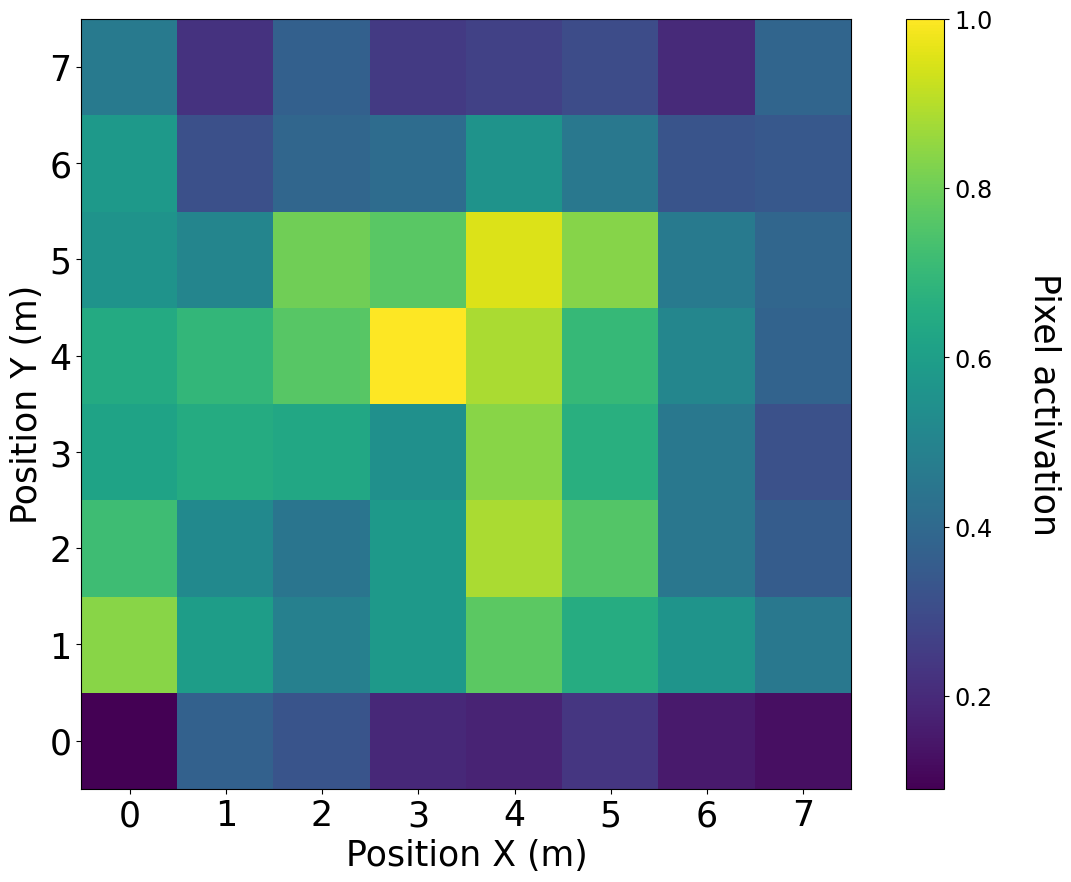

In [15]:
preds = best_model.predict(Model_to_plot)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    Model_to_plot, best_model, last_conv_layer_name, classifier_layer_names
)

height_2 = 10
width_2 = 14

##############################

plt.figure(figsize=(width_2, height_2))

# Display heatmap
plt.imshow(heatmap, origin="lower")
plt.xlabel('Position X (m)', fontsize=25)
plt.xticks(np.arange(0, 8, step=1), fontsize=25)
plt.ylabel('Position Y (m)', fontsize=25)
plt.yticks(np.arange(0, 8, step=1), fontsize=25)

clb = plt.colorbar()
ticklabs = clb.ax.get_yticklabels()
#clb.ax.set_yticklabels(ticklabs, fontsize=20)
clb.set_label('Pixel activation', labelpad=50, y=0.5, rotation=270, fontsize=25)
clb.ax.tick_params(labelsize='xx-large')

#plt.show()

plt.savefig('./Gradcam/pixel_activation_model.jpg', dpi=200)

此代码段执行以下操作：

1. **归一化图像和热图：**
   - 将`Model_to_plot`中的图像归一化到0-255范围，以便与热图相匹配。
   - 对热图进行相似的归一化。

2. **使用Jet colormap着色热图：**
   - 通过`jet` colormap 将灰度热图转换为RGB格式。
   - 将RGB颜色应用于归一化后的热图。

3. **创建RGB彩色热图：**
   - 将Jet colormap着色后的热图转换为图像格式，调整大小以匹配原始图像。
   - 将图像转换为数组。

4. **叠加热图在原始图像上：**
   - 通过将调整大小的RGB热图叠加在归一化的原始图像上，创建一个新的图像。
   - 控制叠加效果的权重为0.3。

5. **可视化结果：**
   - 创建一个包含三个子图的图形窗口，每个子图包括原始模型输出、激活像素图和Grad-CAM图。
   - 使用`contourf`和`imshow`函数显示这三个图。
   - 调整图形元素的标签和刻度的字体大小。
   - 保存可视化结果为PDF文件。

这个过程通过叠加热图在原始图像上，提供了更直观的理解模型关注点的可视化结果。

/tmp/ipykernel_3854298/975354800.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


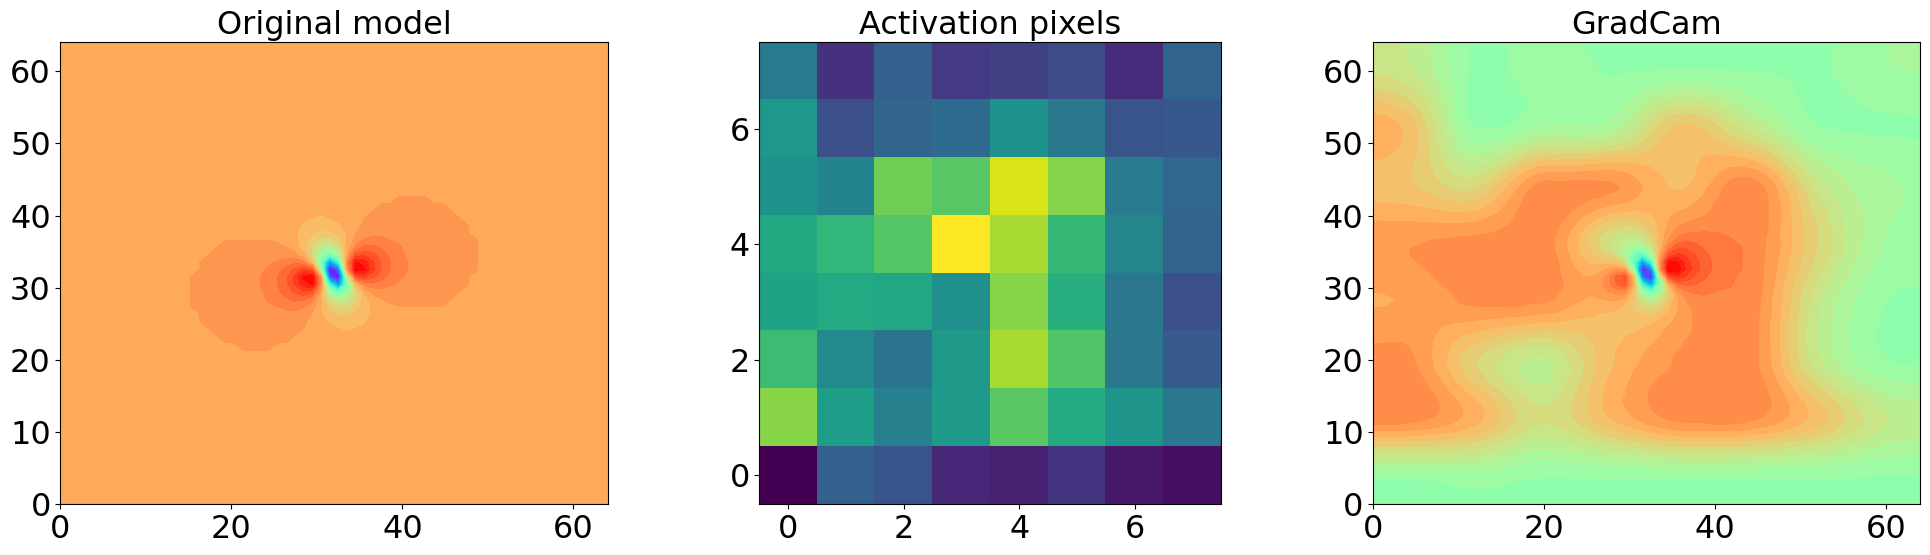

In [16]:
# We rescale heatmap to a range 0-255
image = (Model_to_plot[0,:,:,:] - np.min(Model_to_plot[0,:,:,:])) / (np.max(Model_to_plot[0,:,:,:]) - np.min(Model_to_plot[0,:,:,:]))
image = np.uint8(image*255)  

heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.3 + image
#superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#Display Grad CAM
zmax = X_train.shape[1]
map_lenght = 64

xmin = 0
xmax = map_lenght
ymin = 0
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)

fig, axs = plt.subplots(1,3, figsize=(24,6))
axs = axs.ravel()

font_size = 23
label_size = 23

axs[0].contourf(X, Y, Model_to_plot[0,:,:,0], levels = 40, cmap='rainbow')
axs[0].set_title("Original model", fontsize=font_size)
axs[0].tick_params(labelsize=label_size)
axs[1].imshow(heatmap, origin="lower")
axs[1].set_title("Activation pixels", fontsize=font_size)
axs[1].tick_params(labelsize=label_size)
axs[2].contourf(X, Y, superimposed_img[:,:,0], levels = 40, cmap='rainbow')
axs[2].set_title("GradCam", fontsize=font_size)
axs[2].tick_params(labelsize=label_size)
#plt.imshow(superimposed_img)

plt.savefig('./Gradcam/synthetic_ex.pdf', dpi=200)